In [134]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [135]:
#loading test image
image = cv2.imread('images/answer_sheet_original_marked_one.jpg')

# Preprocessing

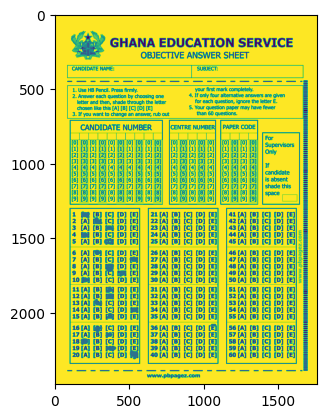

In [136]:
#converting to gray scale
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray)

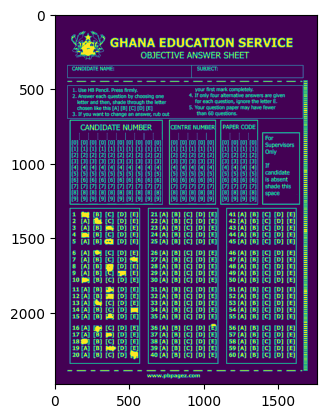

In [137]:
image_noise_reduction = cv2.GaussianBlur(image_gray, (5,5), 1)
_, binary = cv2.threshold(image_noise_reduction, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(binary)

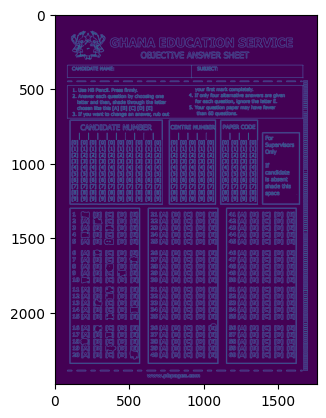

In [138]:
image_edges = cv2.Canny(binary, 10, 50)
plt.imshow(image_edges)

In [139]:
img_contours = image.copy()
contours, hierarchy = cv2.findContours(image_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [140]:
cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 10)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

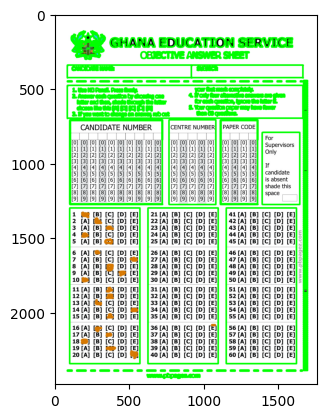

In [141]:
plt.imshow(img_contours)

In [142]:

def rectangle_contour(contours):
    rect_contours = []
    for i in contours:
        area = cv2.contourArea(i)
        if area>100:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02*peri, True)
            if len(approx) == 4:
                rect_contours.append(i)

    rect_contours = sorted(rect_contours, key=cv2.contourArea, reverse=True)
    return rect_contours

rectCon = rectangle_contour(contours)


In [143]:
def getCornerPoints(cont):
    peri = cv2.arcLength(cont, True)
    approx = cv2.approxPolyDP(cont, 0.02*peri, True)
    
    return approx

In [144]:
def reorder(myPoints):
    myPoints = myPoints.reshape((4,2))
    myPointsNew = np.zeros((4,1,2), np.int32)
    add = myPoints.sum(axis=1)
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] = myPoints[np.argmin(add)]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] = myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmin(diff)]

    return myPointsNew
    


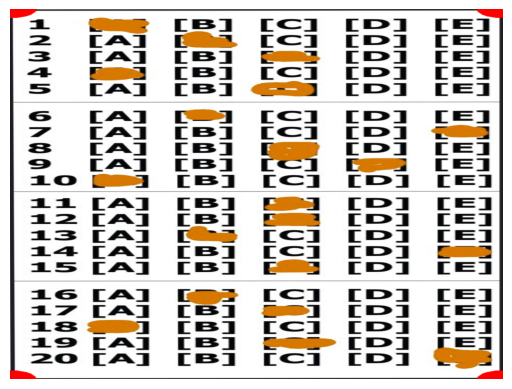

In [145]:
answered_objectives = getCornerPoints(rectCon[2])
img_answered = image.copy()

widthImg = 1200
heightImg = 1600

if answered_objectives.size != 0:
    cv2.drawContours(img_answered, answered_objectives, -1, (255, 0, 0), 50)
    reorder(answered_objectives)

    pt1 = np.float32(answered_objectives)
    pt2 = np.float32([[0,0], [widthImg, 0], [widthImg, heightImg], [0,heightImg]])

    matrix = cv2.getPerspectiveTransform(pt1, pt2)
    imgWarp = cv2.warpPerspective(img_answered, matrix, (widthImg, heightImg))
    imgFlipped = cv2.flip(imgWarp, 1)
    imgRotated = cv2.rotate(imgFlipped, cv2.ROTATE_90_COUNTERCLOCKWISE)

plt.imshow(imgRotated)
plt.axis('off')
plt.show()

In [146]:
# def cropImage(image):
#     image = image[20:375,]
#     return image

In [147]:
# cropped_image = cropImage(img_answered)

#### APPLYING THRESHOLDS TO DETECTED ANSWERED PORTIONS

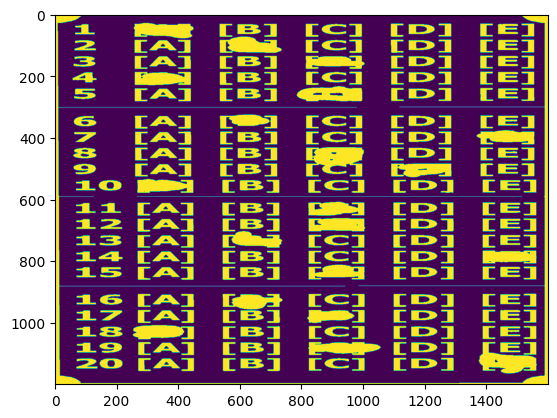

In [148]:
detectedImage = cv2.cvtColor(imgRotated, cv2.COLOR_BGR2RGB)
detectedImage = cv2.cvtColor(imgRotated, cv2.COLOR_RGB2GRAY)
imageThreshold = cv2.threshold(detectedImage, 150, 255, cv2.THRESH_BINARY_INV)[1]
plt.imshow(imageThreshold)

[(0, 295), (295, 590), (590, 885), (885, 1180)]


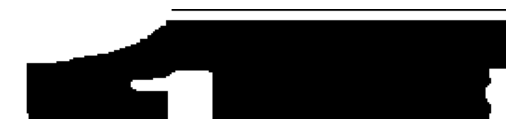

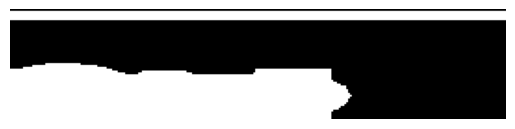

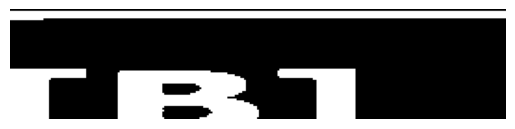

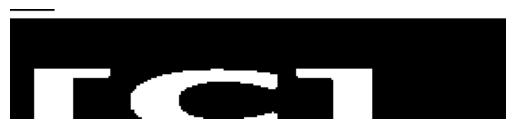

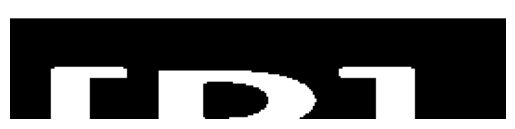

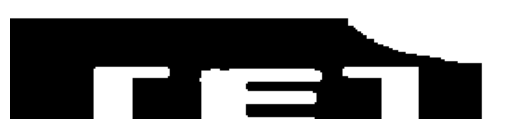

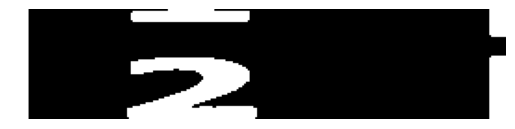

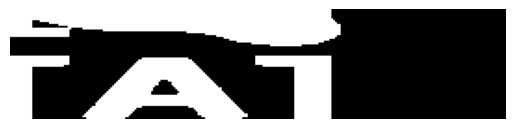

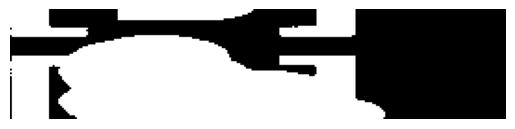

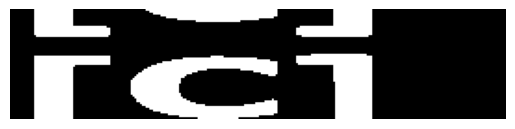

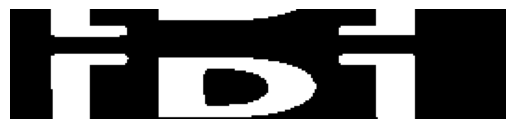

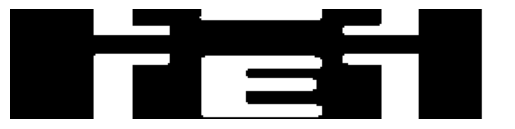

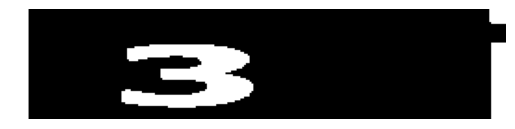

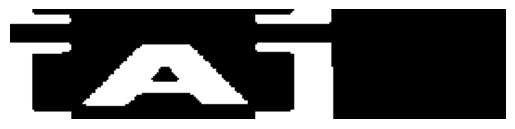

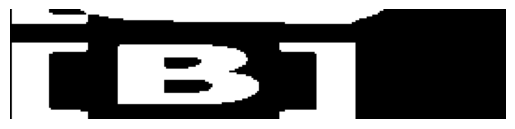

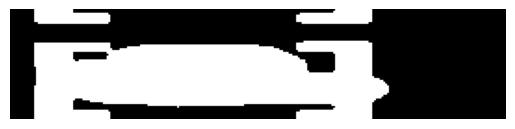

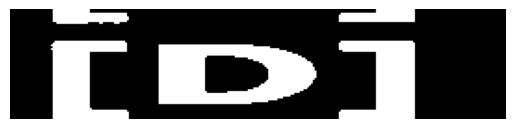

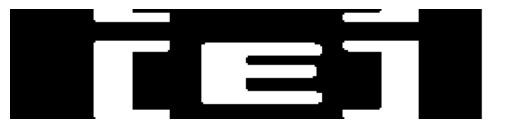

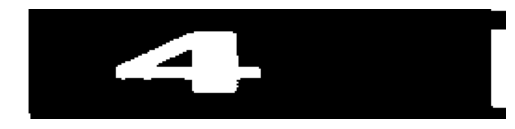

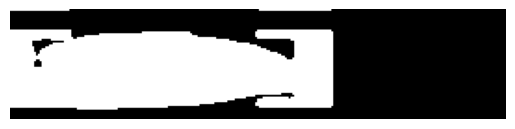

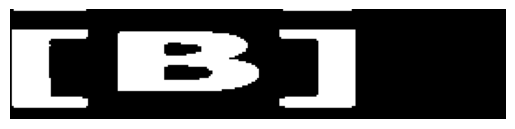

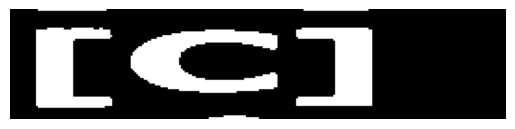

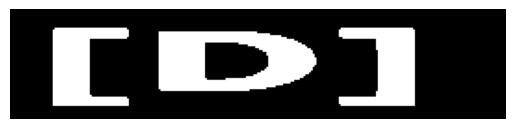

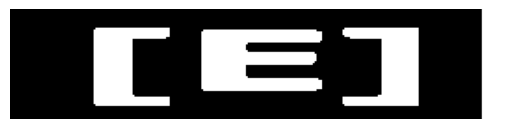

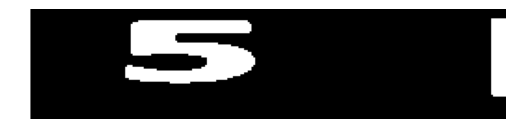

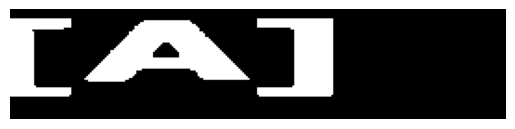

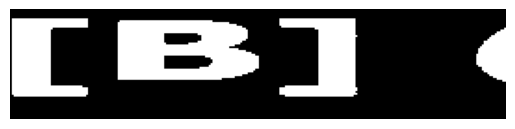

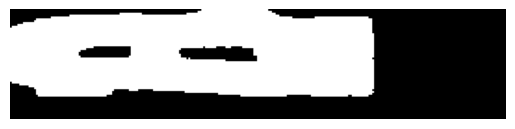

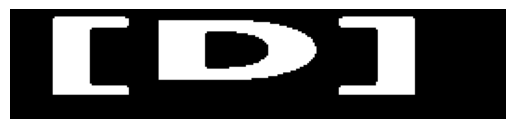

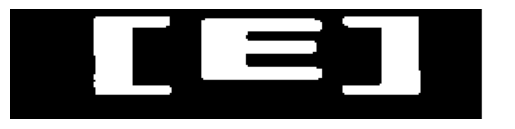

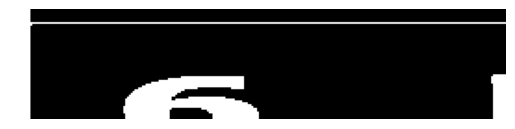

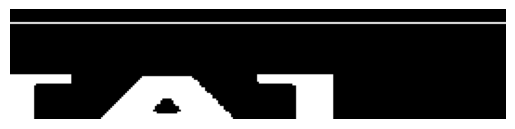

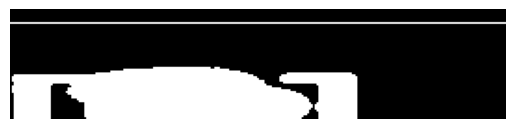

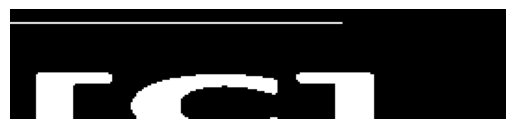

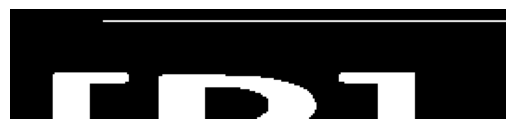

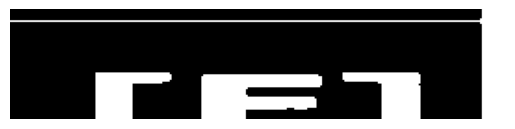

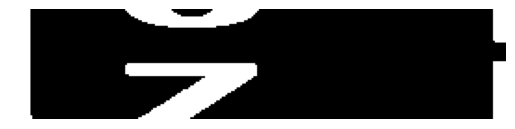

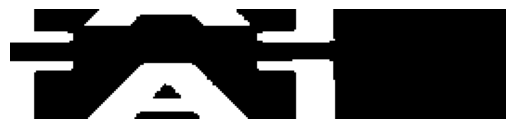

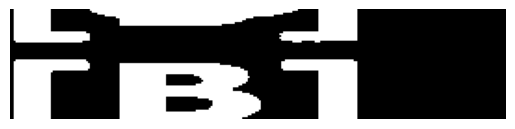

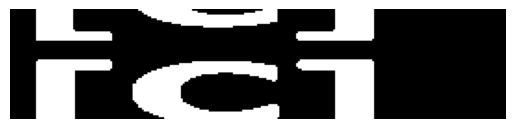

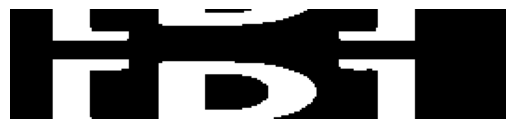

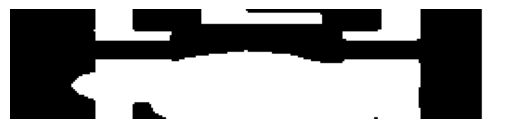

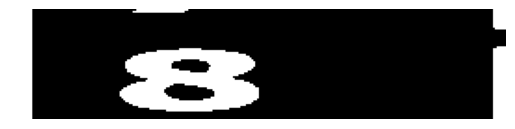

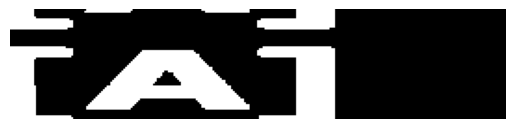

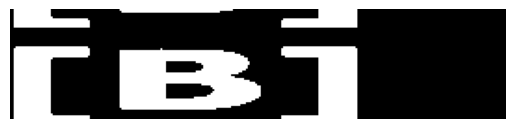

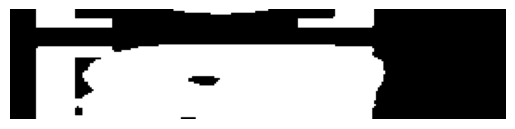

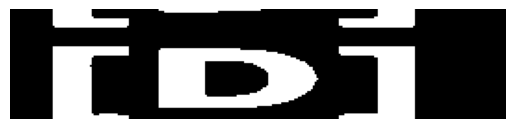

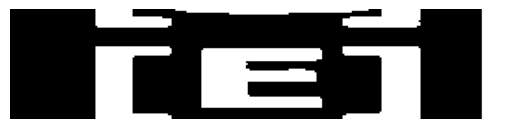

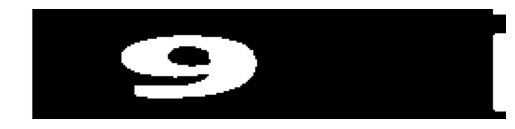

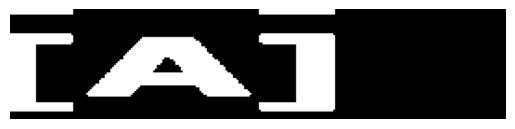

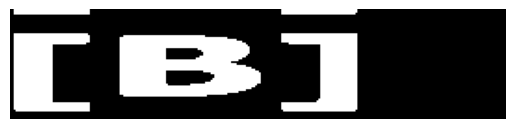

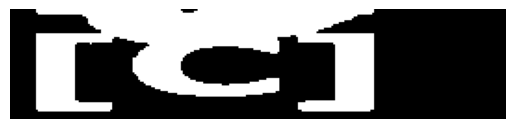

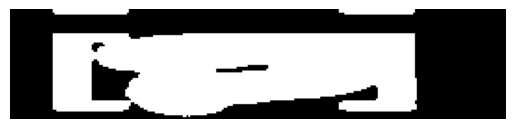

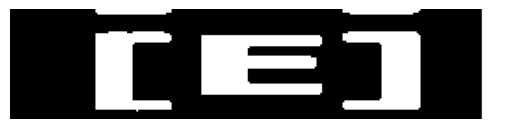

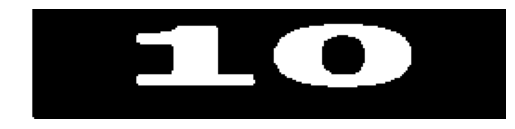

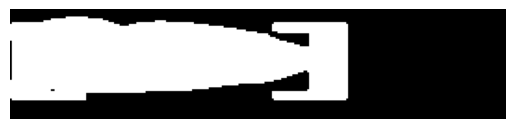

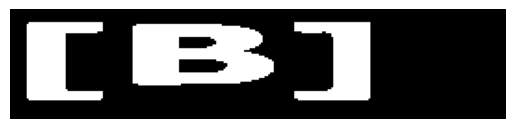

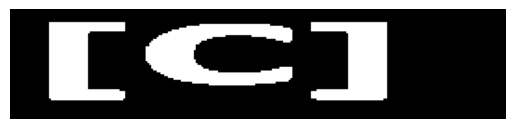

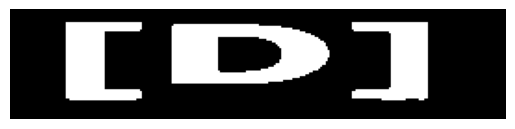

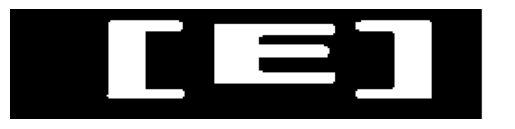

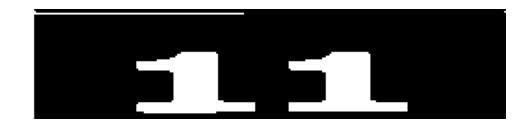

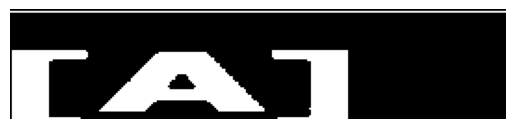

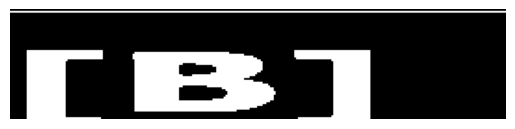

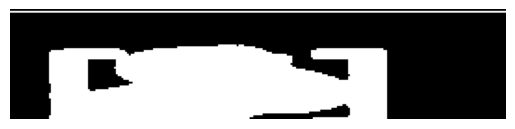

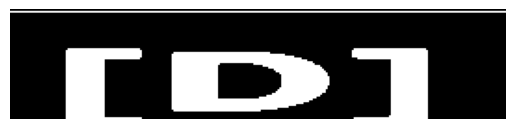

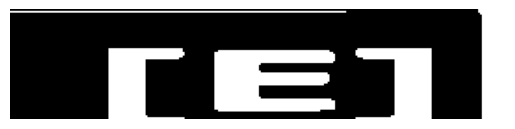

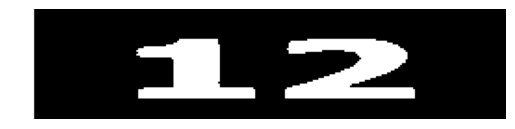

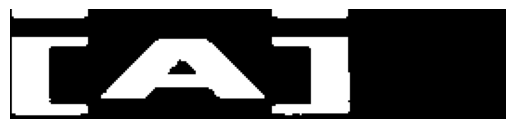

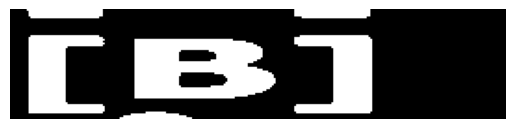

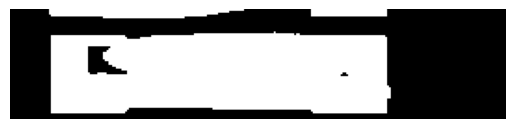

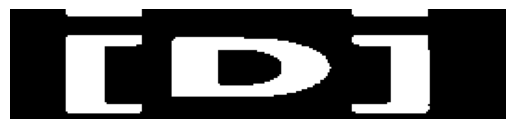

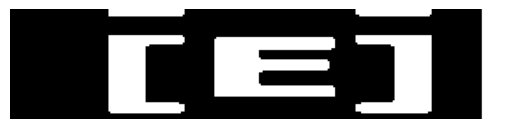

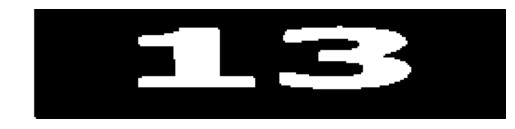

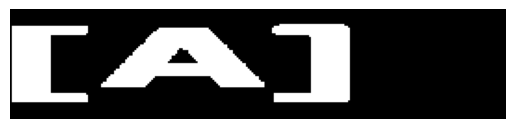

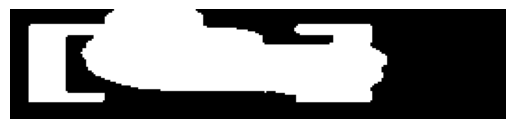

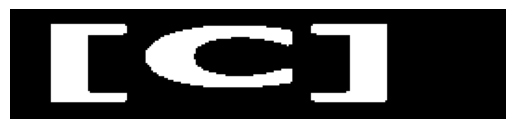

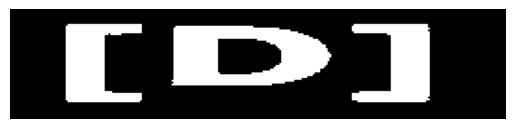

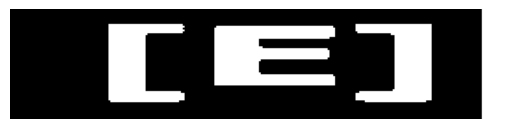

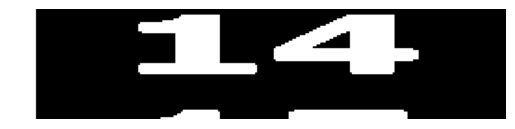

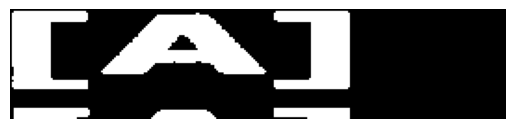

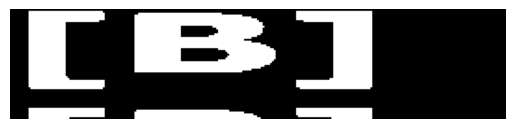

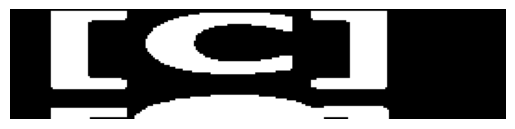

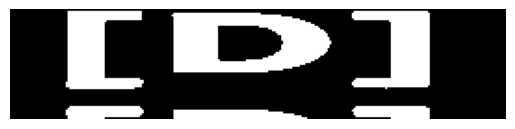

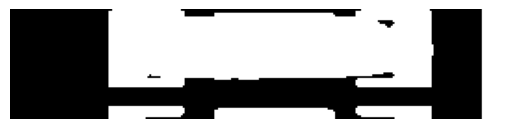

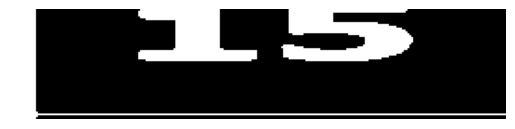

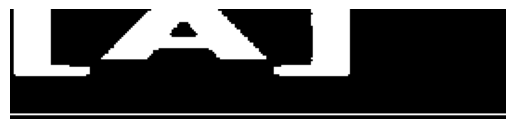

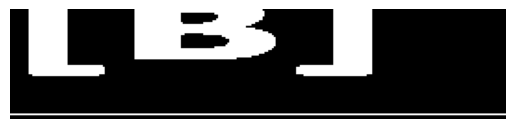

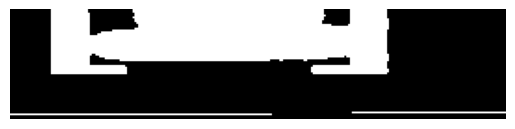

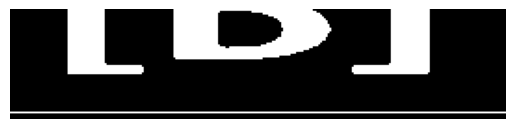

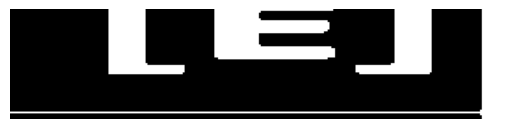

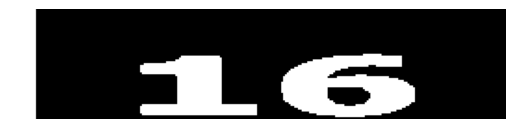

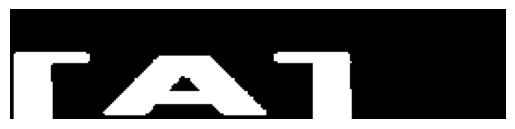

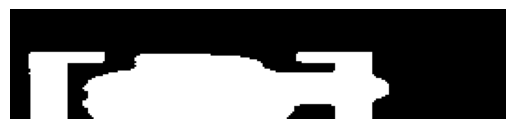

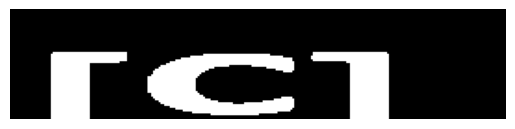

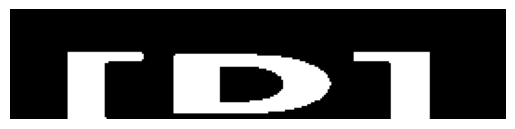

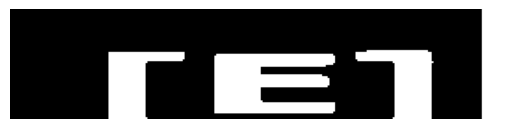

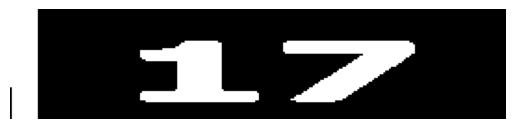

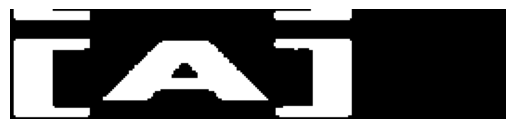

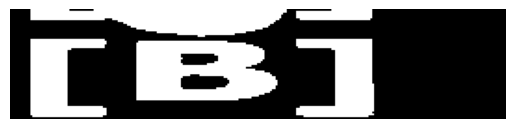

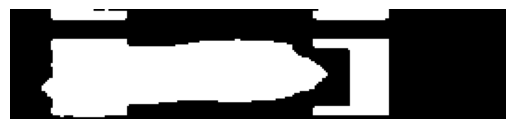

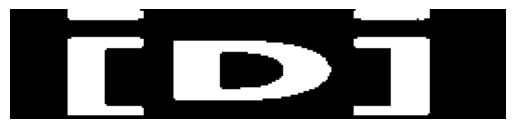

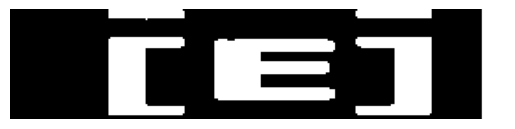

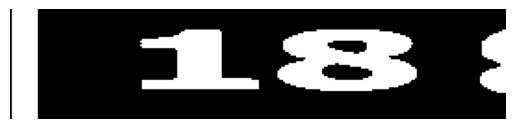

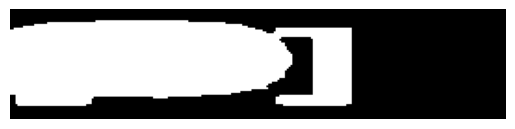

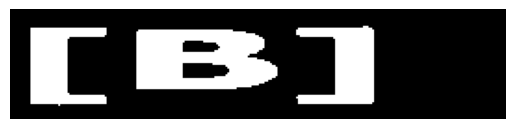

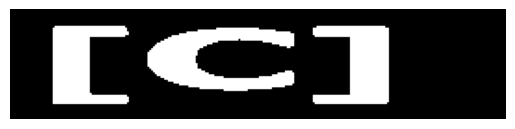

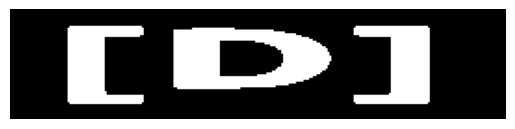

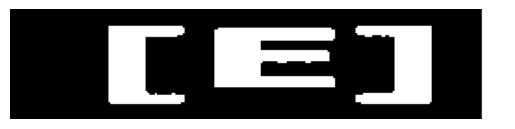

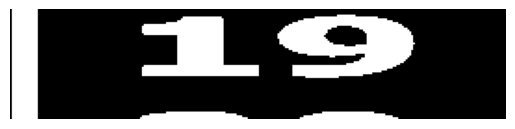

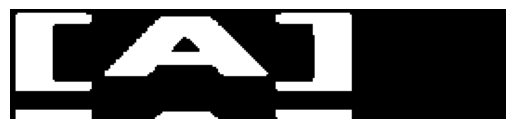

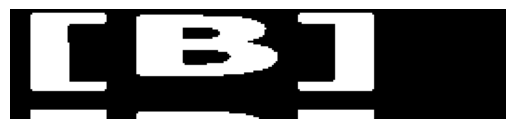

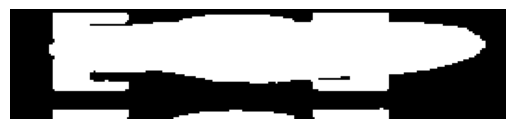

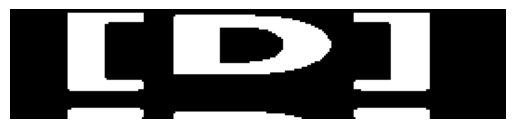

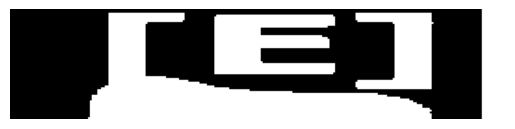

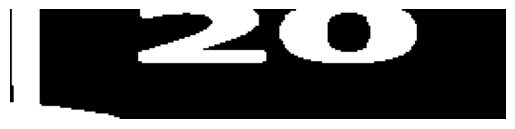

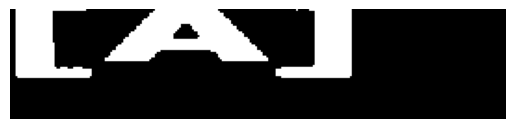

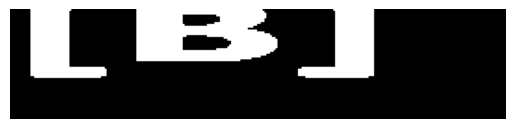

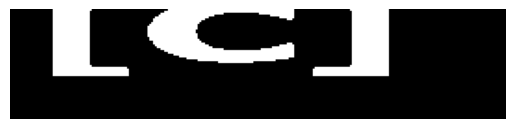

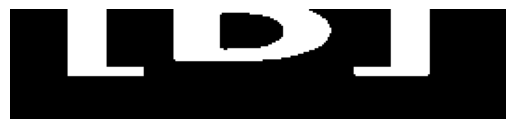

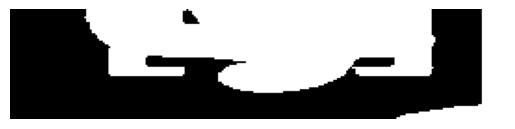

In [149]:
def get_section_coordinates(image_height, num_sections=4):
    section_height = (image_height // num_sections)-5
    coordinates = [(i * section_height, (i + 1) * section_height) for i in range(num_sections)]
    print(coordinates)
    return coordinates


def splitBoxes(img, y_coordinates, splits_per_section=5):
    boxes = []
    for y1, y2 in y_coordinates:
        section = img[y1:y2, :]
        # Ensure the number of rows in the section is divisible by splits_per_section
        pad_size = (splits_per_section - section.shape[0] % splits_per_section) % splits_per_section
        section_padded = np.pad(section, ((0, pad_size), (0, 0)), mode='constant', constant_values=255)

        rows = np.vsplit(section_padded, splits_per_section)
        for row in rows:
            # Ensure the number of columns in the row is divisible by 6
            col_pad_size = (6 - row.shape[1] % 6) % 6
            row_padded = np.pad(row, ((0, 0), (0, col_pad_size)), mode='constant', constant_values=255)
            cols = np.hsplit(row_padded, 6)
            for box in cols:
                boxes.append(box)
    return boxes

# def splitBoxes(img, y_coordinates, splits_per_section=5):
#     boxes = []
#     for y1, y2 in y_coordinates:
#         section = img[y1:y2, :]
#         rows = np.vsplit(section, splits_per_section)
#         for row in rows:
#             boxes.append(row)
#     return boxes

image_height = imageThreshold.shape[0]
y_coordinates = get_section_coordinates(image_height, num_sections=4)

boxes = splitBoxes(imageThreshold, y_coordinates)
for idx, box in enumerate(boxes):
    plt.imshow(box, cmap='gray')
    plt.axis('off')
    plt.show()

In [150]:
number_of_questions = 20
choices = 6
pixelValues = np.zeros((number_of_questions, choices))
countC = 0
countR = 0

for img in boxes:
    totalPixels = cv2.countNonZero(img)
    pixelValues[countR][countC] = totalPixels
    countC +=1
    if countC == choices:
        countR += 1
        countC = 0
print(pixelValues[0])

[4157. 6055. 3927. 3649. 4172. 5920.]


In [151]:
myIndex = []
for x in range(number_of_questions):
    arr = pixelValues[x]
    myIndexVal = np.argmax(arr)  # Find the index of the maximum value in the row
    myIndex.append(myIndexVal)

print(myIndex)

[1, 2, 3, 1, 3, 2, 5, 3, 4, 1, 3, 3, 2, 5, 3, 2, 3, 1, 3, 5]
